In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL


In [2]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     #transforms.Resize(225, 225),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

In [3]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print ('length of train loader = ',len(train_loader))
print ('length of validation loader = ', len(val_loader))
print ('length of test loader = ',len(test_loader))
print ('length of train set = ',len(train_set))
print ('length of validation set = ', len(val_set))
print ('length of test set = ',len(test_set))



Files already downloaded and verified
Files already downloaded and verified
length of train loader =  313
length of validation loader =  79
length of test loader =  79
length of train set =  40000
length of validation set =  10000
length of test set =  10000


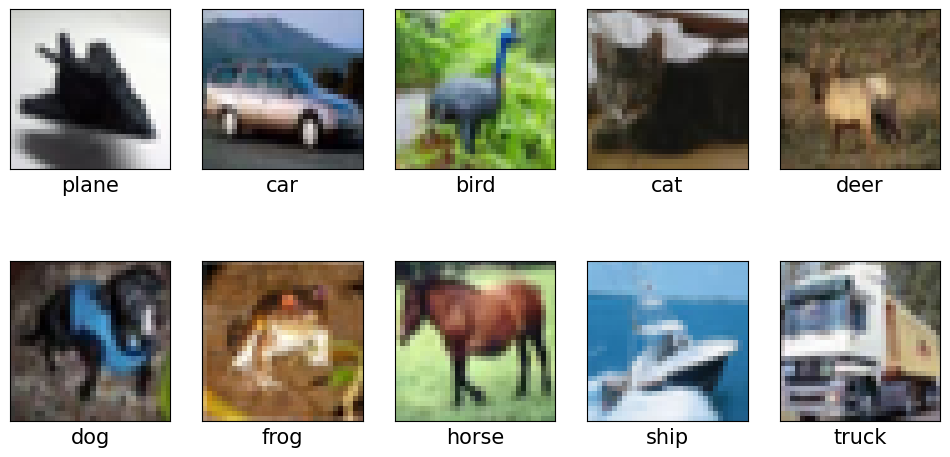

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
fig = [ ]
axes = [ ]
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
from visualize import visualize_data
visualize_data(sample_images, fig, axes,dataset,classes)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

from model import Net

In [6]:
%pip install torchsummary
from torchsummary import summary

net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

summary(net.to(device), input_size=(3, 32, 32))



Device: cpu
Number of trainable parameters: 25352
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             216
       BatchNorm2d-2            [-1, 8, 30, 30]              16
              ReLU-3            [-1, 8, 30, 30]               0
           Dropout-4            [-1, 8, 30, 30]               0
            Conv2d-5            [-1, 8, 30, 30]             576
       BatchNorm2d-6            [-1, 8, 30, 30]              16
              ReLU-7            [-1, 8, 30, 30]               0
           Dropout-8            [-1, 8, 30, 30]               0
            Conv2d-9            [-1, 8, 30, 30]              64
      BatchNorm2d-10            [-1, 8, 30, 30]              16
             ReLU-11            [-1, 8, 30, 30]               0
          Dropout-12            [-1, 8, 30, 30]               0
        MaxPool2d-13            [-1, 8, 15, 15]     


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: C:\Users\SAHITHI\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
import torch.optim as optim
import torch.nn as nn
from utils import model_train

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.01, epochs=20,steps_per_epoch=len(train_loader))

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(20):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch , avg_loss, avg_acc*100, avg_loss_val, avg_acc_val*100))




[epoch 0] loss: 0.00692 accuracy: 68.9175 val loss: 0.00757 val accuracy: 66.7600
[epoch 1] loss: 0.00678 accuracy: 69.2600 val loss: 0.00695 val accuracy: 68.6000
[epoch 2] loss: 0.00674 accuracy: 69.6650 val loss: 0.00729 val accuracy: 67.8400
[epoch 3] loss: 0.00671 accuracy: 69.8600 val loss: 0.00677 val accuracy: 69.9800
[epoch 4] loss: 0.00663 accuracy: 70.2000 val loss: 0.00695 val accuracy: 69.0600
[epoch 5] loss: 0.00661 accuracy: 70.3900 val loss: 0.00676 val accuracy: 70.0300
[epoch 6] loss: 0.00657 accuracy: 70.5650 val loss: 0.00687 val accuracy: 69.3800
[epoch 7] loss: 0.00649 accuracy: 70.6725 val loss: 0.00676 val accuracy: 70.2200
[epoch 8] loss: 0.00651 accuracy: 70.7550 val loss: 0.00677 val accuracy: 70.1200
[epoch 9] loss: 0.00643 accuracy: 71.2675 val loss: 0.00652 val accuracy: 71.4800
[epoch 10] loss: 0.00645 accuracy: 71.1675 val loss: 0.00665 val accuracy: 70.2400
[epoch 11] loss: 0.00642 accuracy: 71.1050 val loss: 0.00650 val accuracy: 71.3400
[epoch 12] los

In [9]:
import torch

torch.save(net.state_dict(), 'checkpoint.pth')

from IPython.display import FileLink

FileLink(r'checkpoint.pth')

net.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

In [10]:
# TESTING
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))


Accuracy on the 10000 test images: 75.34 %


In [ ]:
#Visualize wrongly classified image for each class
import numpy as np

# visualize wrongly classified image for each class
pred_vec = pred_vec.cpu().numpy()
ground_truths = np.asarray(test_set.targets)
incorrect_mask = pred_vec != ground_truths
incorrect_images = [test_set.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results = [pred_vec[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results[i]], fontsize=14)
    axis.imshow(incorrect_images[i])
    i += 1